<a href="https://colab.research.google.com/github/cric96/DL-exercise/blob/main/DL_01_wine_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary part

## Important imports

library reference:
- [pandas](https://pandas.pydata.org/docs/)
- [matplotlib](https://matplotlib.org/)
- [numpy](https://numpy.org/doc/stable/)
- [sklearn](https://scikit-learn.org/stable/)
- [tensorflow](https://www.tensorflow.org/api_docs)
- [seabord](https://seaborn.pydata.org/)

In [ ]:
import glob 
from datetime import datetime
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sb
from xgboost import XGBRegressor ##Another reference as regressor

seed = 42

## Dataset gathering

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

--2021-03-16 21:40:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [application/x-httpd-php]
Saving to: ‘winequality-white.csv.1’

winequality-white.c 100%[===================>] 258.23K   428KB/s    in 0.6s    

2021-03-16 21:40:25 (428 KB/s) - ‘winequality-white.csv.1’ saved [264426/264426]

--2021-03-16 21:40:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv.1’

winequality-red.csv 1

In [ ]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_xlim([1,epoch_count])
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))
  
  for i in range(len(output_labels)):
    axs[0,i].set_title(output_labels[i])
    axs[0,i].scatter(y[:,i], y_pred[:,i],s=1)
    axs[0,i].set_xlabel('True Values')
    if i==0:
      axs[0,i].set_ylabel('Predictions')
    max_value=max(max(y[:,i]),max(y_pred[:,i]))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y[:,i]),min(y_pred[:,i])), max_value]
    axs[0,i].set_xlim(x_lims)
    axs[0,i].set_ylim(y_lims)
    axs[0,i].plot(y_lims, y_lims, color='k')

    errors = y[:,i]-y_pred[:,i]
    axs[1,i].hist(errors, bins=bin_count)
    axs[1,i].set_xlabel('Prediction Error')
    if i==0:
      axs[1,i].set_ylabel('Count')
    axs[1,i].set_xlim([min(errors),max(errors)])

def plot_prediction_results(y,y_pred,output_labels,bin_count=50):
  fig, axs = plt.subplots(2,len(output_labels),figsize=(25, 10))

  def init_plot(top_plot, bottom_plot):
    top_plot.set_ylabel('Predictions')
    bottom_plot.set_ylabel('Count')
    
  def plot_single(top_plot, bottom_plot, y, y_pred, label):
    top_plot.set_title(label)
    top_plot.scatter(y, y_pred, s = 1)
    top_plot.set_xlabel('True Values')
    
    max_value=max(max(y),max(y_pred))
    x_lims = [0, max_value]
    y_lims = [min(0,min(y),min(y_pred)), max_value]
    top_plot.set_xlim(x_lims)
    top_plot.set_ylim(y_lims)
    top_plot.plot(y_lims, y_lims, color='k')

    errors = y - y_pred
    bottom_plot.hist(errors, bins=bin_count)
    bottom_plot.set_xlabel('Prediction Error')
    bottom_plot.set_xlim([min(errors),max(errors)])

  if len(output_labels) == 1:
    init_plot(axs[0], axs[1])
    plot_single(axs[0], axs[1], y, y_pred, output_labels[0])
  else:
    init_plot(axs[0,0], axs[1,0])
    for i in range(len(output_labels)):
      plot_single(axs[0,i], axs[1, i], y[:,i], y_pred[:,i], output_labels[i])

## Dataset analisys and trasformation
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 


**Attributes**
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol
- quality (score between 0 and 10, Output variable)

### Basic analysis

In [ ]:
data_set = pd.read_csv("winequality-red.csv", header = 0, encoding = "unicode_escape", sep = ";") ### Start with only white wine..

In [ ]:
data_set.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


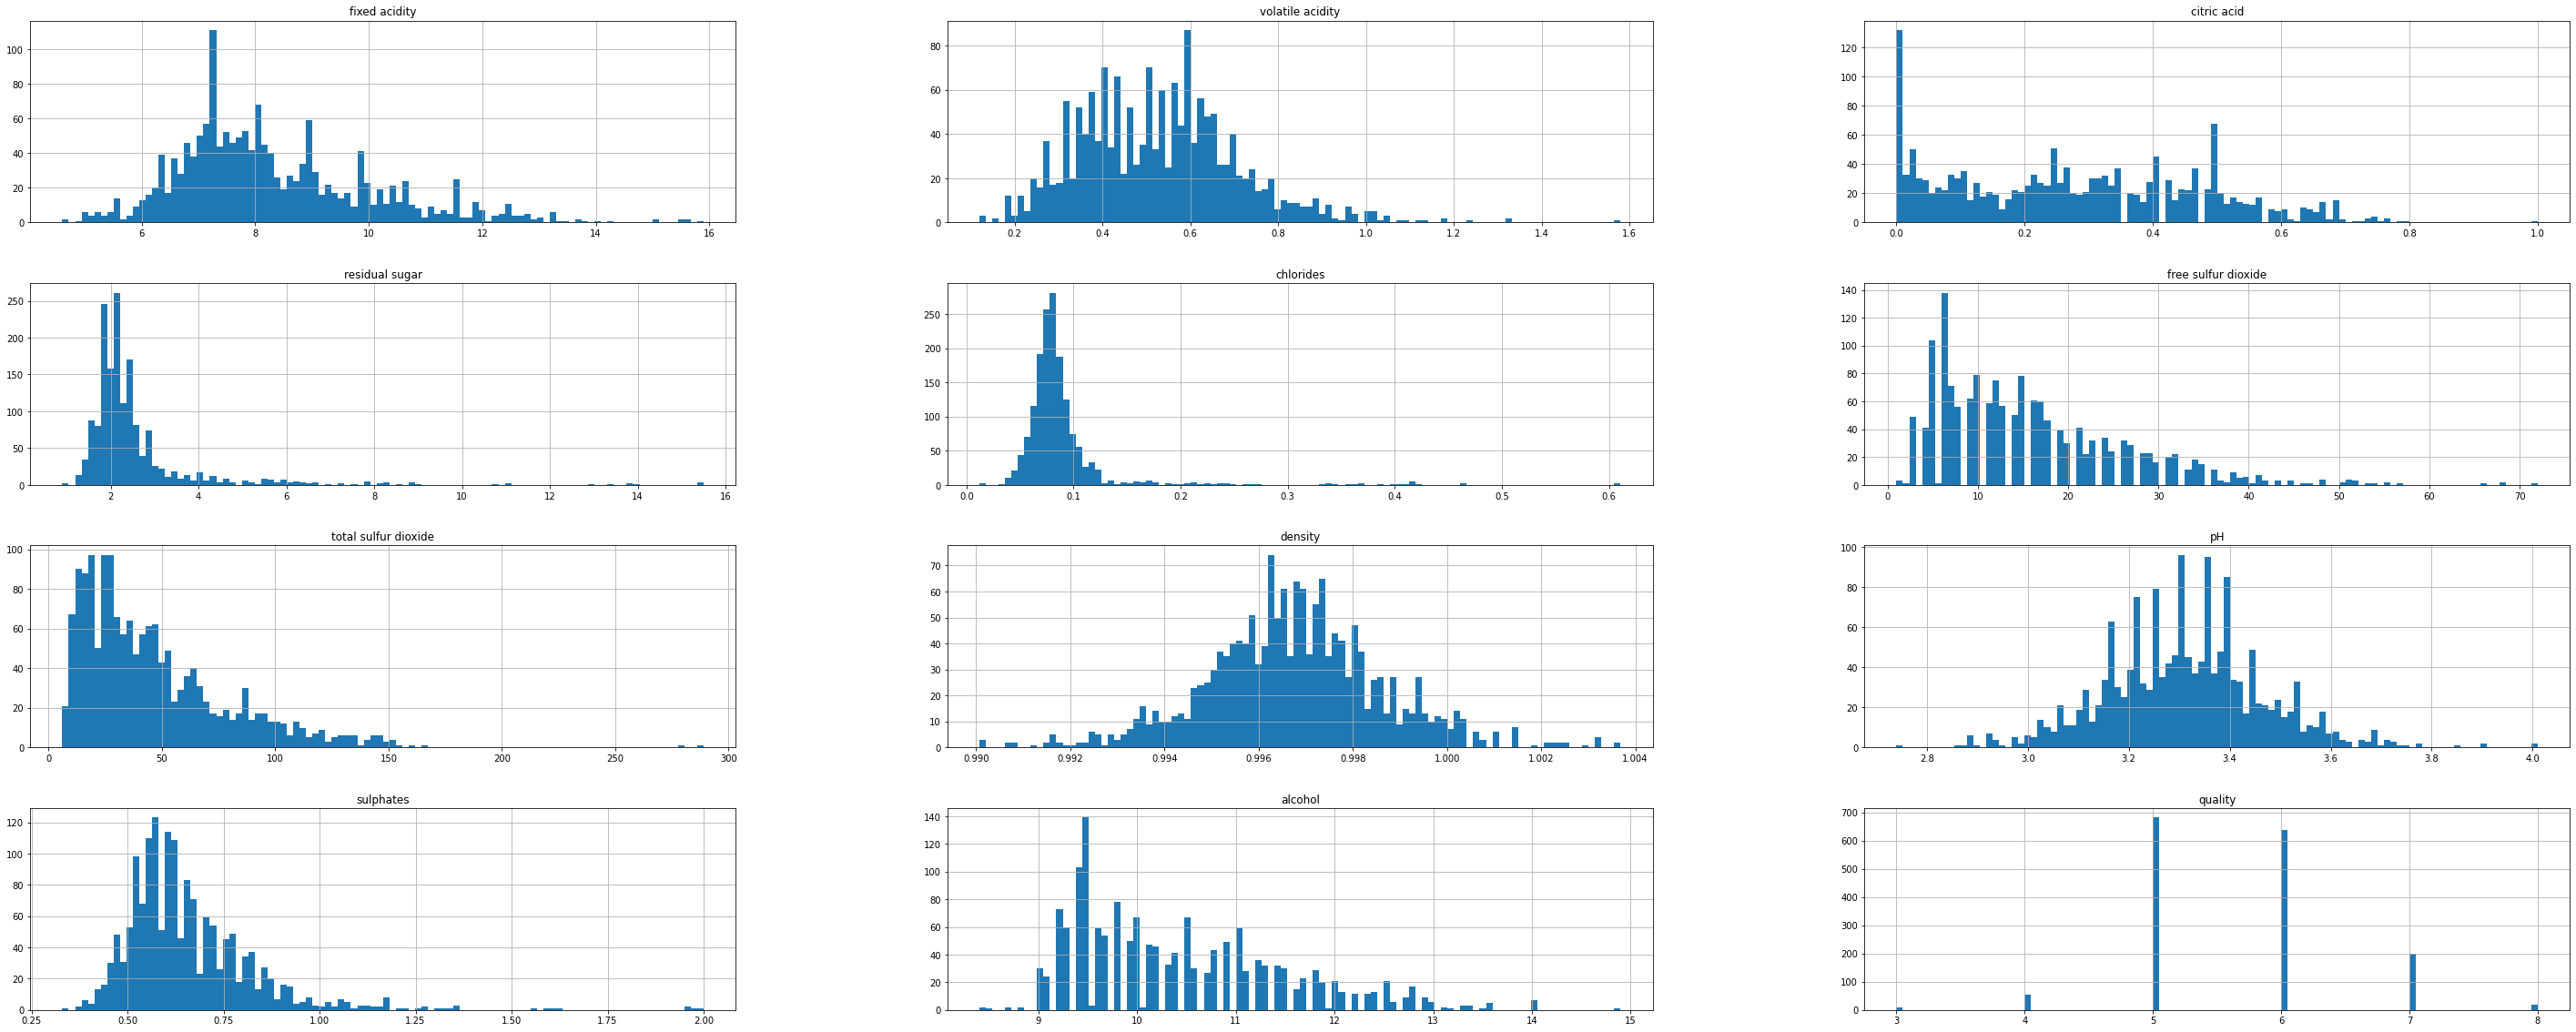

In [ ]:
## Visual information about data
data_set.hist(bins = 100, figsize = (50, 20))
plt.show()

In [ ]:
data_set.columns ## Get all attributes

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4111ebf910>,
      dtype=object)

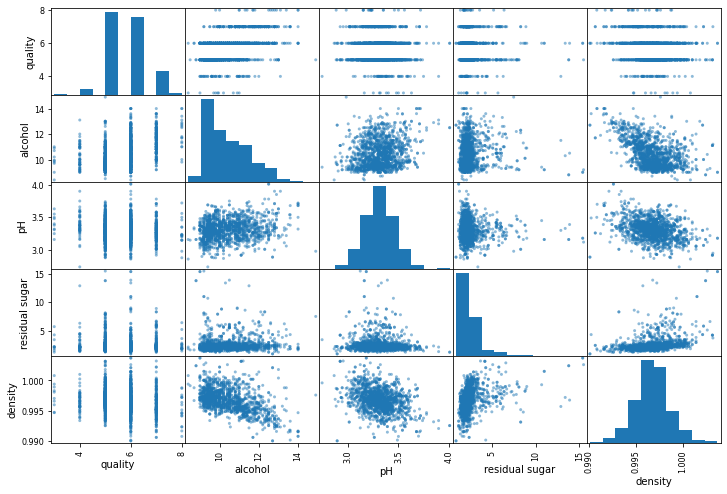

In [ ]:
# Correlation between revelevant data
correlation_with_target = ["quality", "alcohol", "pH", "residual sugar", "density"]
scatter_matrix(data_set[correlation_with_target], figsize = (12, 8))

In [ ]:
corr_matrix = data_set.corr()
corr_matrix["quality"].sort_values(ascending = False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

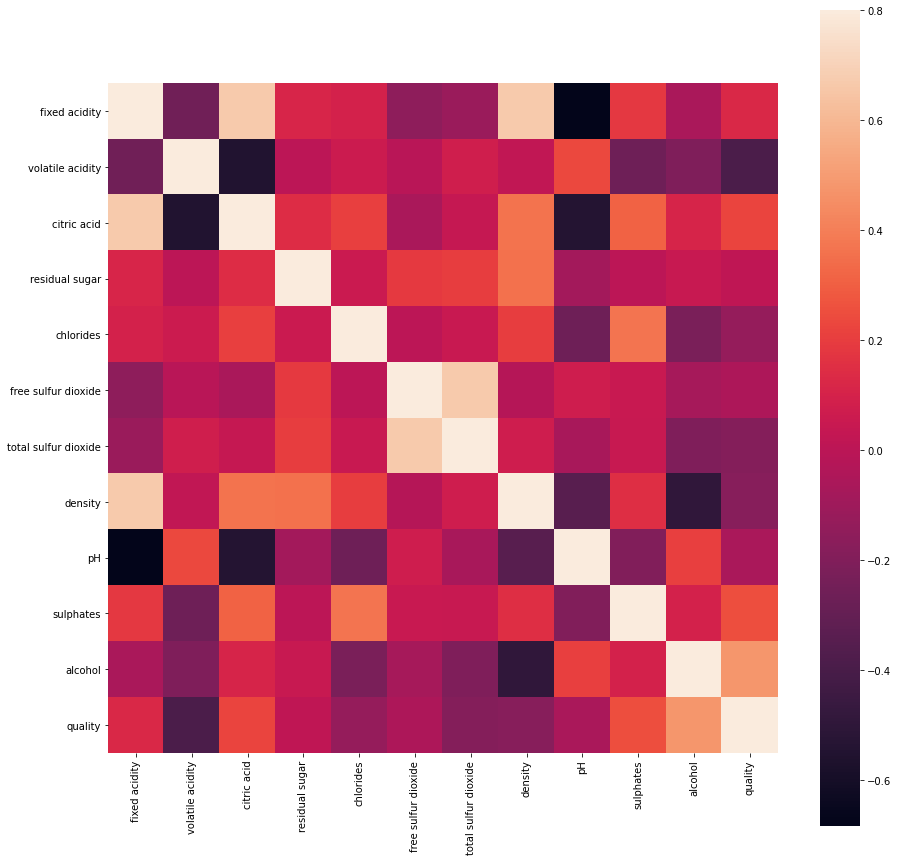

In [ ]:
fig = plt.figure(figsize = (15,15))
sb.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

## Data cleaning

In [ ]:
reference = data_set
### seems nothing to clean
reference.sample(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
433,12.3,0.39,0.63,2.3,0.091,6.0,18.0,1.0004,3.16,0.49,9.5,5


# Learninig part


## Data set splitting

In [ ]:
target = ["quality"]
X = reference.drop(target, axis = 1).values
Y = reference[target].values
test_percentage = 0.25

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = seed, test_size = test_percentage, shuffle = True)

### Scaling the feature

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Reference performance, linear regression

RMSE - Train: 0.654 Test: 0.623


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


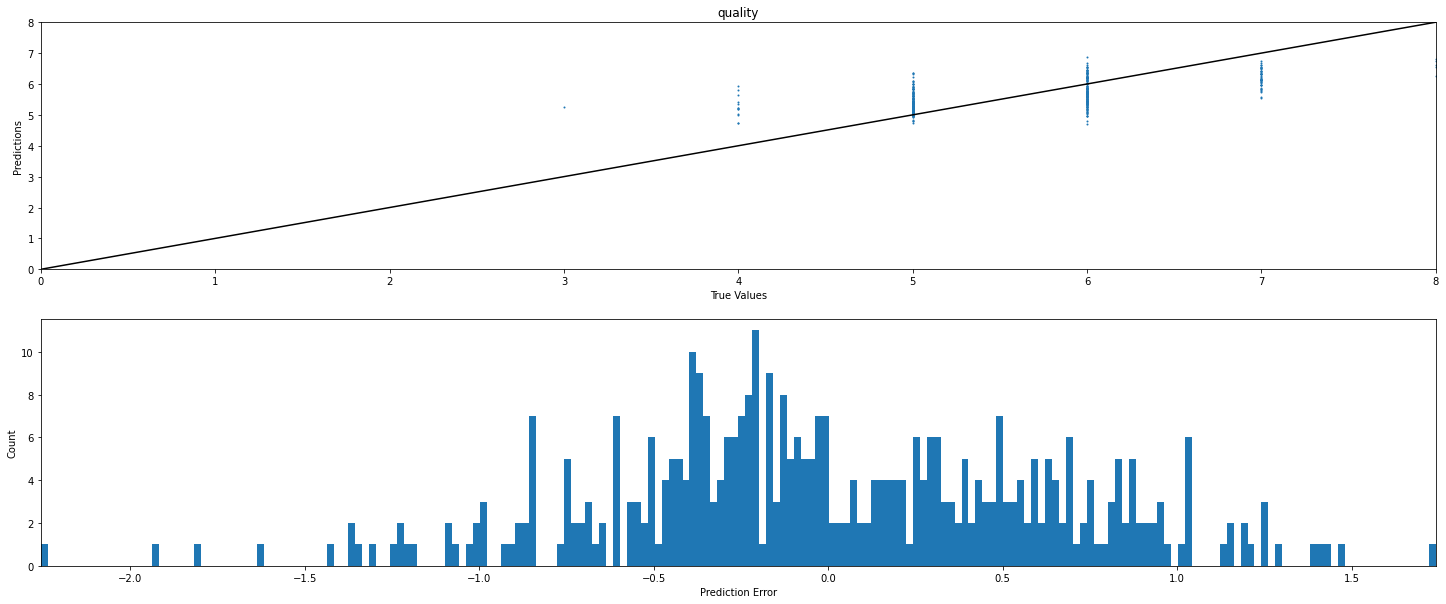

In [ ]:
linear_model = LinearRegression().fit(X_train, Y_train)

rmse_train_error = mean_squared_error(Y_train, linear_model.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, linear_model.predict(X_test), squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))
plot_prediction_results(Y_test, linear_model.predict(X_test), target, 200)

## Reference performance, XGB regressor

[21:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE - Train: 0.491 Test: 0.599


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


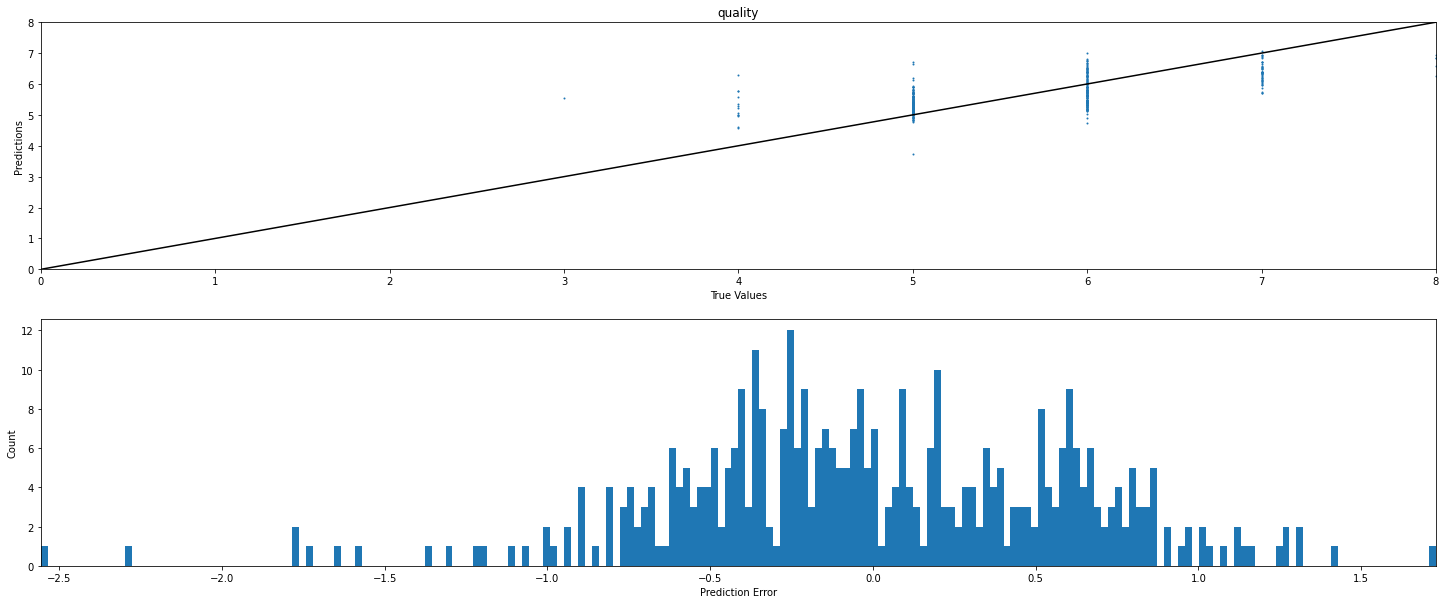

In [ ]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, Y_train)
predition = xgb_regressor.predict(X_test)
to_plot = predition.reshape(predition.shape[0], 1)
rmse_train_error = mean_squared_error(Y_train, xgb_regressor.predict(X_train), squared = False)
rmse_test_error = mean_squared_error(Y_test, predition, squared = False)

print('RMSE - Train: {:.3f} Test: {:.3f}'.format(rmse_train_error, rmse_test_error))

plot_prediction_results(Y_test, to_plot, target, 200)

## Deep learning part

### Validation set creation

In [ ]:
val_size = 0.25

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = val_size, random_state = seed,shuffle = True)


In [ ]:
def build_dnn(input_count, output_count, neuron_count_per_hidden_layer = [128, 128], activation='relu'):
  model = keras.Sequential()
  model.add(layers.Input(shape=(input_count)))

  for n in neuron_count_per_hidden_layer:
    
    model.add(layers.Dense(n, activation = activation))

  model.add(layers.Dense(output_count))

  return model

Traning

In [ ]:
epoch_count = 10000
batch_size = 256
sgd_learning_rate = 0.00001
adam_learning_rate = 0.001
patience = 50
dnn = build_dnn(X_train.shape[1], Y_train.shape[1], [128, 128, 64, 32], activation = 'relu') 
#optimizer = keras.optimizers.SGD(learning_rate = sgd_learning_rate)
#optimizer=keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")
#optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate)
optimizer = keras.optimizers.Adam(learning_rate = adam_learning_rate)
dnn.compile(loss = 'mse', optimizer = optimizer, metrics = [keras.metrics.RootMeanSquaredError(name = 'rmse')])
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)

history = dnn.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs = epoch_count, batch_size = batch_size, shuffle = True, callbacks= [early_stop])

Epoch 1/10000
4/4 [==============================] - 1s 63ms/step - loss: 31.8639 - rmse: 5.6447 - val_loss: 26.7364 - val_rmse: 5.1707
Epoch 2/10000
4/4 [==============================] - 0s 20ms/step - loss: 26.3860 - rmse: 5.1364 - val_loss: 21.3843 - val_rmse: 4.6243
Epoch 3/10000
4/4 [==============================] - 0s 16ms/step - loss: 20.6235 - rmse: 4.5402 - val_loss: 15.0539 - val_rmse: 3.8799
Epoch 4/10000
4/4 [==============================] - 0s 16ms/step - loss: 13.7554 - rmse: 3.7068 - val_loss: 8.3237 - val_rmse: 2.8851
Epoch 5/10000
4/4 [==============================] - 0s 16ms/step - loss: 7.2256 - rmse: 2.6847 - val_loss: 3.6807 - val_rmse: 1.9185
Epoch 6/10000
4/4 [==============================] - 0s 17ms/step - loss: 4.0795 - rmse: 2.0195 - val_loss: 4.1709 - val_rmse: 2.0423
Epoch 7/10000
4/4 [==============================] - 0s 16ms/step - loss: 5.1155 - rmse: 2.2616 - val_loss: 4.0921 - val_rmse: 2.0229
Epoch 8/10000
4/4 [==============================] - 0s

### Evaluation

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


RMSE - Train: 0.438 Val: 0.749 Test: 0.647


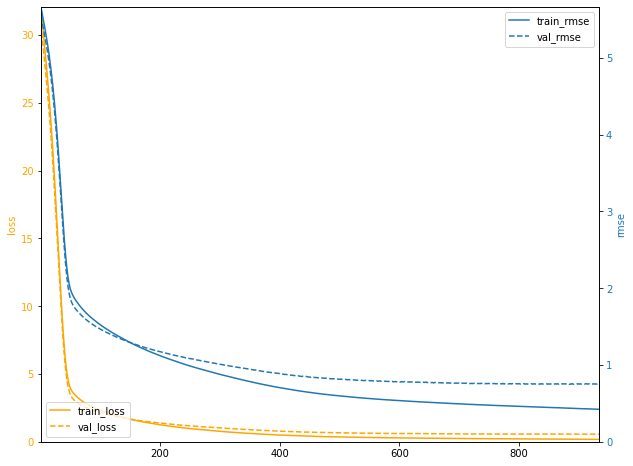

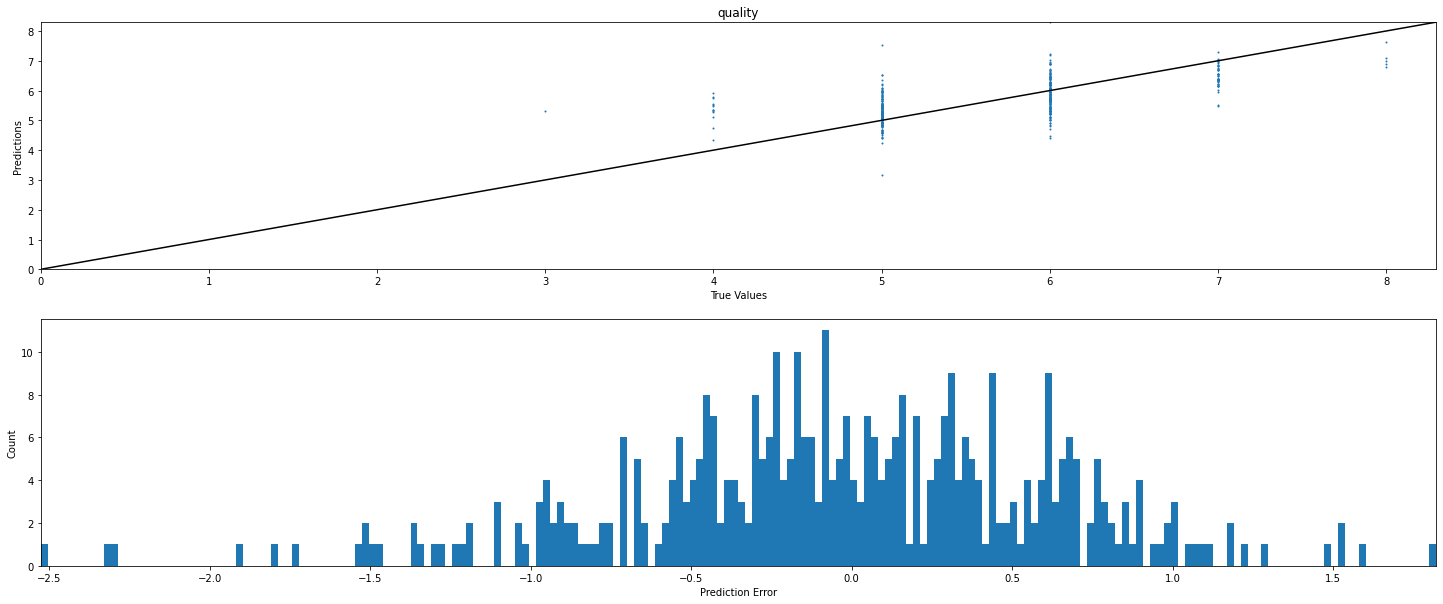

In [ ]:
Y_train_pred = dnn.predict(X_train)
Y_val_pred = dnn.predict(X_val)
Y_test_pred = dnn.predict(X_test)

plot_history(history, 'rmse')
plot_prediction_results(Y_test, Y_test_pred, target, 200)

rmse_train = mean_squared_error(Y_train ,Y_train_pred, squared = False)
rmse_val = mean_squared_error(Y_val, Y_val_pred, squared = False)
rmse_test = mean_squared_error(Y_test, Y_test_pred, squared = False)

print('RMSE - Train: {:.3f} Val: {:.3f} Test: {:.3f}'.format(rmse_train,rmse_val,rmse_test))

In [ ]:
rmse_test_instances = np.sqrt(mean_squared_error(Y_test.transpose(),Y_test_pred.transpose(),multioutput='raw_values'))

rmse_test_instances_sorted_indices = np.argsort(rmse_test_instances)

row_count = 5

print("Best..")
with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[:row_count]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[:row_count]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[:row_count]])


print("Worst...")

with np.printoptions(precision = 1, suppress = True):
  print('RMSE:')
  print(rmse_test_instances[rmse_test_instances_sorted_indices[-row_count:]])

  print('True values:')
  print(Y_test[rmse_test_instances_sorted_indices[-row_count:]])

  print('Predicted values:')
  print(Y_test_pred[rmse_test_instances_sorted_indices[-row_count:]])

Best..
RMSE:
[0. 0. 0. 0. 0.]
True values:
[[6]
 [5]
 [5]
 [6]
 [5]]
Predicted values:
[[6.]
 [5.]
 [5.]
 [6.]
 [5.]]
Worst...
RMSE:
[1.8 1.9 2.3 2.4 2.7]
True values:
[[5]
 [4]
 [3]
 [4]
 [5]]
Predicted values:
[[6.8]
 [5.9]
 [5.3]
 [6.4]
 [7.7]]
